# **Kaggle HW5: Piyush Acharya**

**Remember to write your team name above, which MUST match your team name on Kaggle!!** Assignments without a team name will receive a 0/40 on the "accuracy on test data" component of this assignment's grade.

### **Load the Data**

In [76]:
# This cell is necessary only if you are running on Google Colab. It downloads the files to your
# Colab instance so you don't have to upload them here.

import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
      f.write(r.content)

save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_train.csv',
          'edx_train.csv')
save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_test.csv',
          'edx_test.csv')

### **Sample Code: Random Classifier**

**NOTE**: This classifier **DOES NOT** count as one of the 2 required for this assignment! It is merely here to illstrate how to submit your predictions.

See the Kaggle assignment (Data tab) for a description of each column in the dataset. You are creating a classifier to predict whether or not a student will get certified, stored in the `"certified"` column.

In [77]:
import pandas as pd
from sklearn.dummy import DummyClassifier

target = "certified" # target column

# This classifier returns labels sampled uniformly at random
df_train = pd.read_csv('edx_train.csv')
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(df_train.drop(target, axis=1), df_train[target])

DummyClassifier(strategy='uniform')

The code below generates predictions on the test set, and outputs the predictions into a CSV file.

In [78]:
# Generate predictions on the test set
df_test = pd.read_csv('edx_test.csv')
predictions = dummy_model.predict(df_test)

# Save your predictions as a CSV
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = predictions
to_save.to_csv('submission.csv', index=False)

# See below for instructions on how to upload submission.csv to Kaggle,
# in order to evaluate your model and get points.

### **[5 Pts] Model Comparison**

**Instructions**: Run at least 2 different classification models. The classification models we have learned in class are: [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [Decision Trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [Random Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), and [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), [Neural Networks](https://scikit-learn.org/stable/modules/neural_networks_supervised.html). For each model, try at least 2 different hyperparameter settings.

Then, make one or more visualizations that let you compare the models you trained. Sample visualizations you can make include confusion matrices, or graphs of train and validation accuracy/error. See past section and homework code for how to make these visualizations.

## Hyperparameters changed

In [79]:
import pandas as pd
import numpy as np
import sklearn
import torch
from sklearn.preprocessing import StandardScaler

In [80]:
def preprocess(df):
    categorical_cols = ["course_id", "final_cc_cname_DI", "LoE_DI", "gender"]

    for col in categorical_cols:
        df[col] = pd.Categorical(df[col]).codes
    for date in ["last_event_DI", "start_time_DI"]:
        df[date] = pd.to_datetime(df[date]).astype("int64") // 10**9

    df = df.fillna(-1)

    return df

In [81]:
from sklearn.model_selection import train_test_split

df_train = pd.read_csv("edx_train.csv")
df_test = pd.read_csv("edx_test.csv")

df_train = preprocess(df_train)
df_test = preprocess(df_test)

X_train = df_train.drop(["certified", "userid_DI"], axis=1)
Y_train = df_train["certified"]

test = df_test.drop(["userid_DI"], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
Y_val_scaled = scaler.transform(Y_val)
test_scaled = scaler.transform(test)

C:\Users\achar\AppData\Local\Temp\ipykernel_49988\3490461305.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date] = pd.to_datetime(df[date]).astype("int64") // 10**9
C:\Users\achar\AppData\Local\Temp\ipykernel_49988\3490461305.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date] = pd.to_datetime(df[date]).astype("int64") // 10**9
C:\Users\achar\AppData\Local\Temp\ipykernel_49988\3490461305.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date] = pd.to_datetime(df[date]).astype("int64") // 10**9
C:\Users\achar\AppData\Local\Temp\ipykernel_49988\34904613

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [ ]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
Y_train_tensor = torch.FloatTensor(Y_train.values)

X_val_tensor = torch.FloatTensor(X_val_scaled)
Y_val_tensor = torch.FloatTensor(Y_val.values)

X_test_tensor = torch.FloatTensor(test_scaled)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_set = TensorDataset(X_train_tensor, Y_train_tensor)
val_set = TensorDataset(X_val_tensor, Y_val_tensor)
test_set = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

In [ ]:
from torch.nn import ReLU
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.dropout(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout(torch.relu(self.bn2(self.fc2(x))))
        x = self.dropout(torch.relu(self.bn3(self.fc3(x))))
        x = self.dropout(torch.relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)
        return x


==== Training NetE ====
Epoch [1/400], Loss: 0.4445, Train Accuracy: 0.9376, Validation Accuracy: 0.9458
Epoch [2/400], Loss: 0.2737, Train Accuracy: 0.9408, Validation Accuracy: 0.9446
Epoch [3/400], Loss: 0.2252, Train Accuracy: 0.9450, Validation Accuracy: 0.9486
Epoch [4/400], Loss: 0.1988, Train Accuracy: 0.9492, Validation Accuracy: 0.9555
Epoch [5/400], Loss: 0.1795, Train Accuracy: 0.9533, Validation Accuracy: 0.9561
Epoch [6/400], Loss: 0.1657, Train Accuracy: 0.9573, Validation Accuracy: 0.9589
Epoch [7/400], Loss: 0.1556, Train Accuracy: 0.9559, Validation Accuracy: 0.9595
Epoch [8/400], Loss: 0.1527, Train Accuracy: 0.9600, Validation Accuracy: 0.9589
Epoch [9/400], Loss: 0.1487, Train Accuracy: 0.9580, Validation Accuracy: 0.9612
Epoch [10/400], Loss: 0.1436, Train Accuracy: 0.9615, Validation Accuracy: 0.9623
Epoch [11/400], Loss: 0.1406, Train Accuracy: 0.9633, Validation Accuracy: 0.9663
Epoch [12/400], Loss: 0.1397, Train Accuracy: 0.9616, Validation Accuracy: 0.9623
E

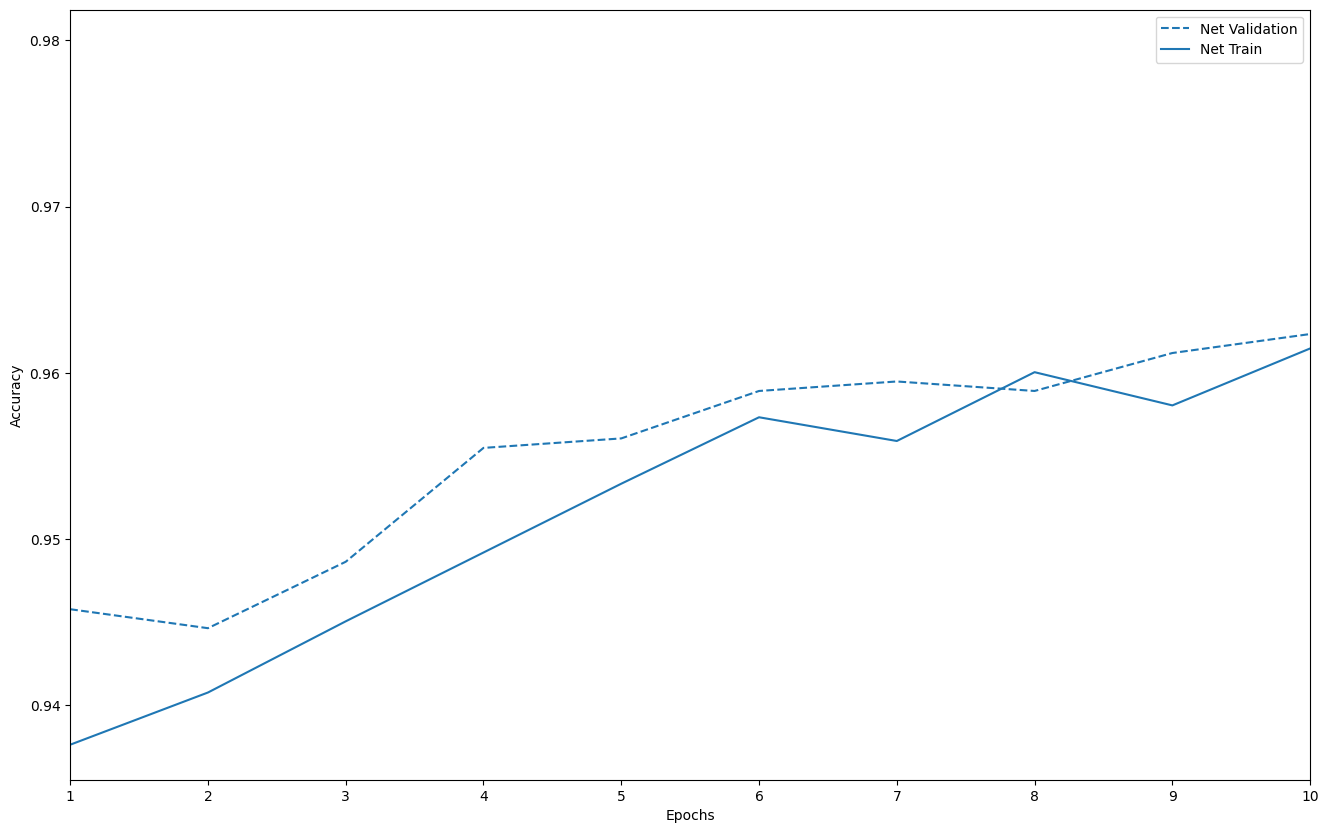

In [ ]:
import matplotlib.pyplot as plt

def train(net, train_loader, val_loader, num_epochs, learning_rate, compute_accs=False):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

    train_accs, val_accs = [], []

    for epoch in range(1, num_epochs + 1):
        net.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = net(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)
            total_loss += loss.item()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss)

        if compute_accs:
            train_acc = accuracy(net, train_loader)
            val_acc = accuracy(net, val_loader)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

    return train_accs, val_accs

def accuracy(net, data_loader):
    net.eval()
    correct = total = 0
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = net(batch_X)
            predicted = (outputs > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted.squeeze() == batch_y).sum().item()
    return correct / total


def plot_history(histories):
    plt.figure(figsize=(16,10))
    epochs = range(1, len(histories[0]['train_accs']) + 1)
    for history in histories:
        val = plt.plot(epochs, history['val_accs'], '--', label=f"{history['name']} Validation")
        plt.plot(epochs, history['train_accs'], color=val[0].get_color(), label=f"{history['name']} Train")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,10])
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netE = Net(X_train.shape[1]).to(device)

print('==== Training NetE ====')
train_history_E, val_history_E = train(netE, train_loader, val_loader,
      num_epochs=600, learning_rate=1e-4, compute_accs=True)
plot_history([{'name': 'Net', 'train_accs': train_history_E, 'val_accs': val_history_E}])

netE.eval()
with torch.no_grad():
    predictions = (netE(X_test_tensor.to(device)).squeeze() > 0.5).float().cpu().numpy()


# submission file
pd.DataFrame({
    'userid_DI': df_test['userid_DI'],
    'certified': predictions.astype(int)
}).to_csv('submission.csv', index=False)

## Original

C:\Users\achar\AppData\Local\Temp\ipykernel_49988\2111754613.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date] = pd.to_datetime(df[date]).astype("int64") // 10**9
C:\Users\achar\AppData\Local\Temp\ipykernel_49988\2111754613.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date] = pd.to_datetime(df[date]).astype("int64") // 10**9
C:\Users\achar\AppData\Local\Temp\ipykernel_49988\2111754613.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date] = pd.to_datetime(df[date]).astype("int64") // 10**9
C:\Users\achar\AppData\Local\Temp\ipykernel_49988\21117

==== Training NetE ====
Epoch [1/400], Loss: 0.7053, Train Accuracy: 0.5808, Validation Accuracy: 0.5771
Epoch [2/400], Loss: 0.6839, Train Accuracy: 0.5936, Validation Accuracy: 0.5902
Epoch [3/400], Loss: 0.6639, Train Accuracy: 0.6052, Validation Accuracy: 0.6005
Epoch [4/400], Loss: 0.6416, Train Accuracy: 0.5943, Validation Accuracy: 0.5919
Epoch [5/400], Loss: 0.6276, Train Accuracy: 0.6556, Validation Accuracy: 0.6444
Epoch [6/400], Loss: 0.6065, Train Accuracy: 0.6643, Validation Accuracy: 0.6570
Epoch [7/400], Loss: 0.5905, Train Accuracy: 0.6826, Validation Accuracy: 0.6809
Epoch [8/400], Loss: 0.5704, Train Accuracy: 0.7268, Validation Accuracy: 0.7306
Epoch [9/400], Loss: 0.5567, Train Accuracy: 0.7334, Validation Accuracy: 0.7323
Epoch [10/400], Loss: 0.5440, Train Accuracy: 0.7632, Validation Accuracy: 0.7643
Epoch [11/400], Loss: 0.5292, Train Accuracy: 0.7932, Validation Accuracy: 0.7979
Epoch [12/400], Loss: 0.5168, Train Accuracy: 0.8132, Validation Accuracy: 0.8134
E

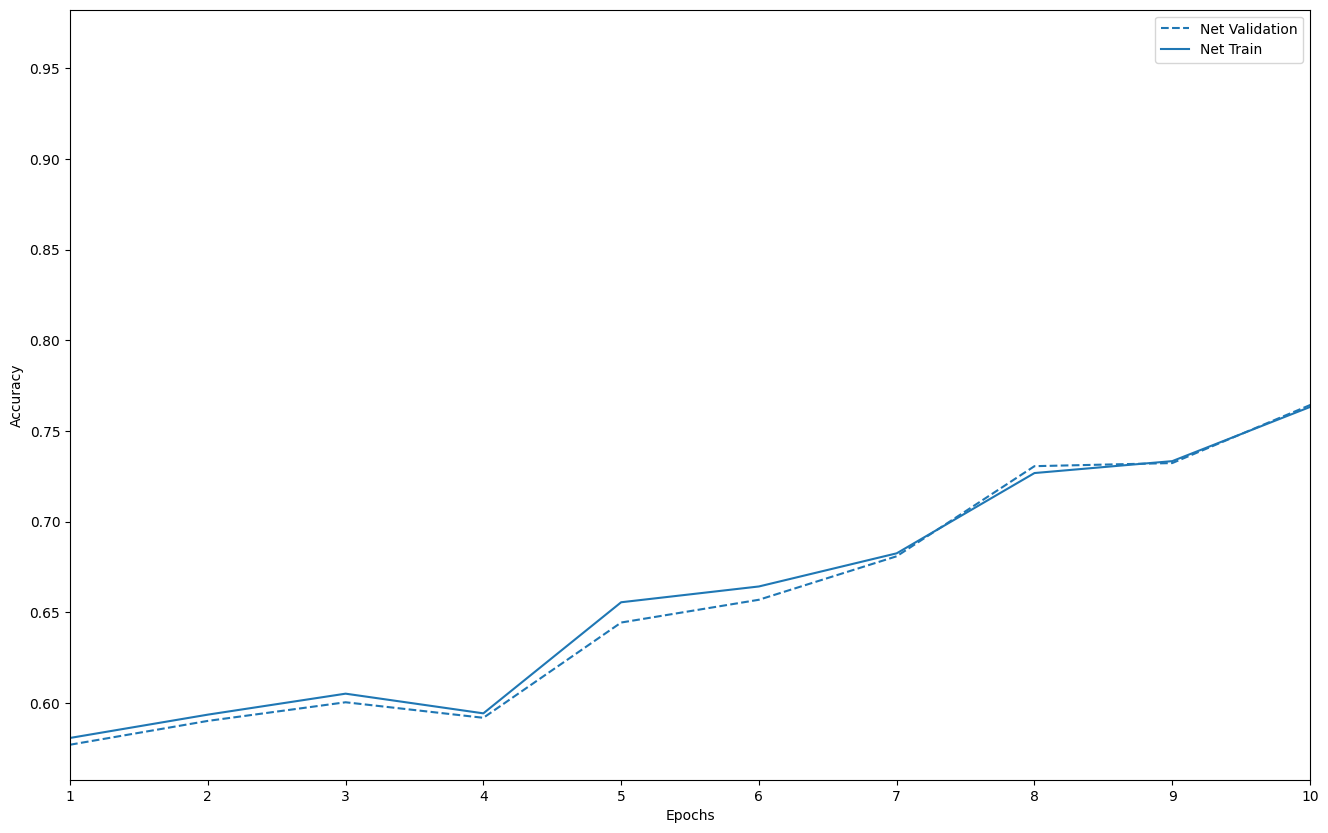

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import torch
from sklearn.preprocessing import StandardScaler


def preprocess(df):
    categorical_cols = ["course_id", "final_cc_cname_DI", "LoE_DI", "gender"]

    for col in categorical_cols:
        df[col] = pd.Categorical(df[col]).codes
    for date in ["last_event_DI", "start_time_DI"]:
        df[date] = pd.to_datetime(df[date]).astype("int64") // 10**9

    df = df.fillna(-1)

    return df


from sklearn.model_selection import train_test_split

df_train = pd.read_csv("edx_train.csv")
df_test = pd.read_csv("edx_test.csv")

df_train = preprocess(df_train)
df_test = preprocess(df_test)

X_train = df_train.drop(["certified", "userid_DI"], axis=1)
Y_train = df_train["certified"]

test = df_test.drop(["userid_DI"], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test)


X_train_tensor = torch.FloatTensor(X_train_scaled)
Y_train_tensor = torch.FloatTensor(Y_train.values)

X_val_tensor = torch.FloatTensor(X_val_scaled)
Y_val_tensor = torch.FloatTensor(Y_val.values)

X_test_tensor = torch.FloatTensor(test_scaled)

from torch.utils.data import TensorDataset, DataLoader

train_set = TensorDataset(X_train_tensor, Y_train_tensor)
val_set = TensorDataset(X_val_tensor, Y_val_tensor)
test_set = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)


from torch.nn import ReLU
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.dropout(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout(torch.relu(self.bn2(self.fc2(x))))
        x = self.dropout(torch.relu(self.bn3(self.fc3(x))))
        x = self.dropout(torch.relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)
        return x


def train(net, train_loader, val_loader, num_epochs, learning_rate, compute_accs=False):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-7)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=8)

    train_accs, val_accs = [], []

    for epoch in range(1, num_epochs + 1):
        net.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = net(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)
            total_loss += loss.item()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss)

        if compute_accs:
            train_acc = accuracy(net, train_loader)
            val_acc = accuracy(net, val_loader)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

    return train_accs, val_accs

def accuracy(net, data_loader):
    net.eval()
    correct = total = 0
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = net(batch_X)
            predicted = (outputs > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted.squeeze() == batch_y).sum().item()
    return correct / total


def plot_history(histories):
    plt.figure(figsize=(16,10))
    epochs = range(1, len(histories[0]['train_accs']) + 1)
    for history in histories:
        val = plt.plot(epochs, history['val_accs'], '--', label=f"{history['name']} Validation")
        plt.plot(epochs, history['train_accs'], color=val[0].get_color(), label=f"{history['name']} Train")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,10])
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netE = Net(X_train.shape[1]).to(device)

print('==== Training NetE ====')
train_history_E, val_history_E = train(netE, train_loader, val_loader,
      num_epochs=400, learning_rate=0.01e-4, compute_accs=True)
plot_history([{'name': 'Net', 'train_accs': train_history_E, 'val_accs': val_history_E}])

netE.eval()
with torch.no_grad():
    predictions = (netE(X_test_tensor.to(device)).squeeze() > 0.5).float().cpu().numpy()

Original KNN

Accuracy: 0.9612


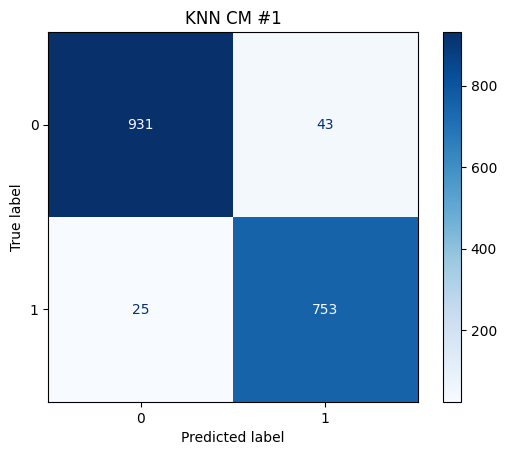

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, Y_train)

Y_pred = knn.predict(X_val_scaled)

accuracy = np.mean(Y_pred == Y_val)
print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(Y_val, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('KNN CM #1')
plt.show()

Hyperparameters changed

Accuracy: 0.9680


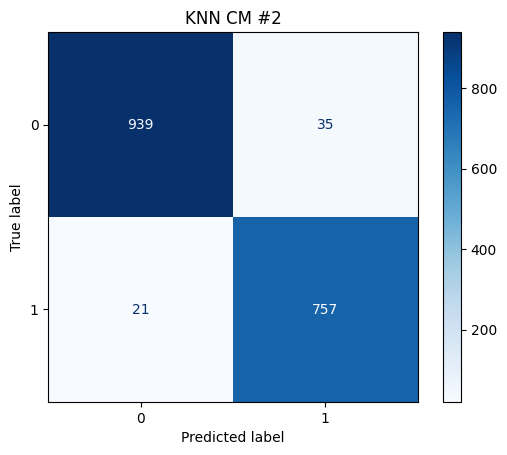

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=12,
    weights='distance',
    algorithm='auto',
    leaf_size=65,
    p=1.5,
    metric='minkowski',
    n_jobs=-1
)

knn.fit(X_train_scaled, Y_train)

Y_pred = knn.predict(X_val_scaled)
accuracy = np.mean(Y_pred == Y_val)
print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(Y_val, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('KNN CM #2')
plt.show()

**Remember to submit your submissions CSV FILE on Kaggle!** 40 pts come from your accuracy on the private test data.

Attend section on Thurs 5/11 for a demo of how to uppload submissions to Kaggle. We also have screenshots below (ingore summer and homework number in pictures)

Step 1: See the list of files on Colab

![See Colab Files](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/1_colab_see_files.jpg)

Step 2: Download `submission.csv`

![Download Colab File](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/2_colab_download_file.jpg)

Step 3: Join the Kaggle competition.

![Join the Kaggle Competition](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/3_kaggle_join_competition.jpg)

Step 4: Enusre your team name in Kaggle matches the one at the top of this notebook!

![Check Team Name](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/4_kaggle_team_name.jpg)

Step 5: Upload `submission.csv` to Kaggle

![Upload submission.csv](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/6_kaggle_upload_submission.jpg)



### **Discussion**



#### **[7 Pts] Training the Models**

**Instructions**: Discuss what models you tried, and what you did to improve your initial predictions. Discuss what hyperparameters you tried, and which hyperparameters seemed important for your final model. Finally, discuss what you are inferring from the above visualiation(s).

Initially, I tried using a 5-layer custom neural network with full connected layers, dropout layers, and 1 dimensional batch normalization.

For hyperparameter tuning, I adjusted:
* Learning rate (from 0.01e-4 to 1e-4)
* Weight decay (from 1e-7 to 1e-5)
* Dropout rate (from 0.2 to 0.3)
* Number of epochs (400)

The number of epochs definitely helped improve the model to a certain extent, but as the train/validation error *graphs* show, this has diminishing returns after a certain point. So, I would argue that changing the learning rate had the greatest effect. Also, the graphs show that the validation error of the tuned model is lower than the original model, which is a good sign that the model is not overfitting.

I also tweaked the learning rate scheduling using ReduceLROnPlateau, which I learned about from the documentation.

The other model I tried was the k-Nearest Neighbors model. I tried many hyperparameters, including:

* Number of neighbors (from 3 to 12)
* Weights set from ('uniform' to 'distance')
* Algorithm set to ('auto')
* Leaf size (from 30 to 65)
* P value for Minkowski distance (from 2 to 1.5)

The weights set to distance helped to improve the model to the greatest extent because as we discussed in class, the distance of the neighbors should be taken into account when making predictions. The number of neighbors also had a significant effect on the model since it performed a lot better with a higher number of neighbors.

The confusion matrix for the kNN demonstrates that the TP rate for the tuned model is a lot higher than the original model, which is a good sign.

#### **[3 Pts] Feature Selection**

**Instructions**: Discuss what features you used and whether you did some transformations on them. What features seemed important for your final model?

I used categorical data such as "course_id", "final_cc_cname_DI", "LoE_DI", and "gender", which were encoded using pd.Categorical().codes

I converted date columns ("last_event_DI", "start_time_DI") were converted to Unix timestamps so that they would be processed by the model in a numerical way. Missing values were filled with -1.

The most important features for the final model were the "course_id" and "final_cc_cname_DI" columns as I found by testing.

#### **[5 Pts] Ethical Implications**

**Instructions**: Consider and discuss the ethical implications of using the model you trained. Imagine you were hired to work as a data scientist for an online education platform (exciting, right?). They want to use your model to predict which students they should tailor their course material towards so they can maximize their profits. Their idea is to use the model to help predict which student groups (i.e. from specific countries or certain educational backgrounds) would make them the most money by getting the most participants to complete their paid certificate program. Are there any ethical considerations we should think about before acting on that plan?

Using a model to discriminate people based on their country and educational background will be unethical because it will perpetuate existing educational inequalities in the world. The purpose of a MOOC is to make university education more accessible to other people, so by using a model to discriminate against certain groups of people, the company would be going against its own mission. It might also be unethical to be using the students' data to make profit without their consent. Overall, in the long term, it would have a negative effect.